### Objective Function

$$
\min_{\{\pi_t, x_t, r_t\}_{t=1}^T} \quad \frac{1}{2} \sum_{t=1}^{T} \beta^t \left[ (\pi_t - \pi^*)^2 + \omega (x_t)^2 \right]
$$

- Where $\pi^*$ it the inflation target, in this case 2%

### Structural Equations

**Phillips Curve with Cost-Push Shock**

$$
\pi_t = \gamma x_t + \beta \pi_{t+1} + u_t
$$

**IS Curve**

$$
x_t = x_{t+1} - \frac{1}{\sigma} (r_t - \pi_{t+1} - \bar{r})
$$

### Shock Process

**Initial Shock**

$$
u_1 = \pi_0 - \gamma x_0 - \beta \pi_0
$$

**AR(1) Shock Dynamics**

$$
u_t = \rho_u u_{t-1}
$$

### Interest Rate Constraints

**Interest Rate Smoothing**

$$
-0.5 \leq r_t - r_{t-1} \leq 0.5
$$

**Zero Lower Bound**

$$
r_t \geq 0
$$

**10 Upper Bound**

$$
r_t \leq 10
$$


## Non Stochastic Model

In [1]:
using JuMP, Ipopt

# Parameters
T = 48       # Time horizon
β = 0.99     # Discount factor
γ = -0.08    # Slope of Phillips Curve
σ = 1.0      # Intertemporal elasticity of substitution
ω = 0.5      # Weight on output gap in loss function
ρ_u = 0.8    # Persistence of cost-push shock
u₁ = 1.0     # Initial cost-push shock
λ = 0.1      # Weight to smooth interest rates between quarters

# Model setup
model = Model(Ipopt.Optimizer)
set_silent(model)

# Variables
@variables(model, begin
    pi_[1:T]      # Inflation
    x[1:T]      # Output gap
    i[1:T]      # Nominal interest rate
    u[1:T]      # Cost-push shock (AR(1))
end)

# Shock process
@constraint(model, u[1] == u₁)
@constraint(model, [t=2:T], u[t] == ρ_u * u[t-1])

# Phillips Curve (with cost-push shock)
@constraint(model, [t=1:T-1], pi_[t] == γ * x[t] + β * pi_[t+1]+ u[t])

# IS Curve (assuming natural rate rₜᶠ = 2% for simplicity)
@constraint(model, [t=1:T-1], x[t] == x[t+1] - (1/σ) * (i[t] - pi_[t+1] - 2.0))

# ZLB Constraint
@constraint(model, [t=1:T], i[t] >= 0.0)

# Upper Bound Constraint on interest
@constraint(model, [t=1:T], i[t] <= 10.0)

# Objective: Minimize loss function (πₜ² + ωxₜ²)
@objective(model, Min, sum(β^(t-1) * ((pi_[t] - 2)^2 + ω * x[t]^2 + λ * (i[t]-i[t-1])^2) for t in 2:T))

# Solve
optimize!(model)

# Extract results
π_opt = value.(pi_)
x_opt = value.(x)
i_opt = value.(i)
u_opt = value.(u)

"""Taylor Rule Comparison for Performance Validation"""

function taylor_rule(π_path, x_path, r_star=2.0, π_target=2.0)
    φ_π, φ_x = 1.5, 0.5  # Standard Taylor rule coefficients
    return [max(0.0, r_star + π + φ_π*(π - π_target) + φ_x*x) 
            for (π, x) in zip(π_path, x_path)]
end

# Calculate Taylor rule benchmark
i_taylor = taylor_rule(π_opt, x_opt)

# Performance comparison
function calculate_loss(π, x, i_prev, β=0.99, ω=0.5, λ=0.1, π_target=2.0)
    loss = (π[1] - π_target)^2 + ω * x[1]^2  # Period 1
    for t in 2:length(π)
        loss += β^(t-1) * ((π[t] - π_target)^2 + ω * x[t]^2 + λ * (i_prev[t] - i_prev[t-1])^2)
    end
    return loss
end

opt_loss = calculate_loss(π_opt, x_opt, i_opt)
taylor_loss = calculate_loss(π_opt, x_opt, i_taylor)
improvement = (taylor_loss - opt_loss) / taylor_loss * 100

println("Performance vs Taylor Rule:")
println("  Optimal Policy Loss: $(round(opt_loss, digits=4))")
println("  Taylor Rule Loss: $(round(taylor_loss, digits=4))")
println("  Improvement: $(round(improvement, digits=2))%")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Performance vs Taylor Rule:
  Optimal Policy Loss: 25.9408
  Taylor Rule Loss: 27.1736
  Improvement: 4.54%


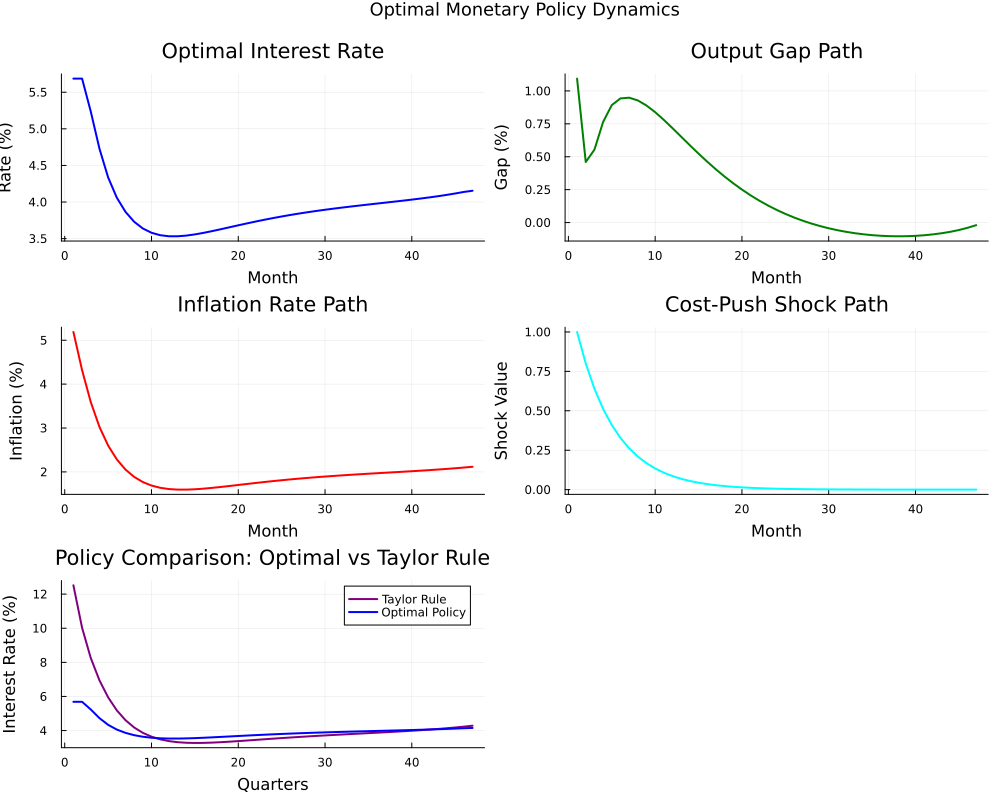

In [2]:
using Plots

# Parameters
time_period = 1:T-1  # Use full time horizon (T instead of T-1)

# Extract paths - use array comprehension for cleaner code
r_path = [value(i[t]) for t in time_period]    # Changed from r to i to match variable names
x_path = [value(x[t]) for t in time_period]    # Changed from X to x for consistency
π_path = [value(pi_[t]) for t in time_period]  # Changed from pi_ to π for consistency
u_path = [value(u[t]) for t in time_period]    # shock path

quarters = 1:T-1  # Use full range

# Create individual plots with improved formatting
p1 = plot(quarters, r_path,
     label = nothing,  # Removed legend for cleaner look
     xlabel = "Month", ylabel = "Rate (%)",
     title = "Optimal Interest Rate",
     linewidth = 2,
     color = :blue,
     grid = true)

p2 = plot(quarters, x_path,
     label = nothing,
     xlabel = "Month", ylabel = "Gap (%)",
     title = "Output Gap Path",
     linewidth = 2,
     color = :green,
     grid = true)

p3 = plot(quarters, π_path,
     label = nothing,
     xlabel = "Month", ylabel = "Inflation (%)",
     title = "Inflation Rate Path",
     linewidth = 2,
     color = :red,
     grid = true)

p4 = plot(quarters, u_path,
     label = nothing,
     xlabel = "Month", ylabel = "Shock Value",
     title = "Cost-Push Shock Path",
     linewidth = 2,
     color = :cyan,
     grid = true)

p5 = plot(quarters, i_taylor[1:end-1],
          label = "Taylor Rule",
          linewidth = 2,
          color = :purple,
          grid = true)

# Overlay the optimal path
plot!(p5, quarters, r_path,
      label = "Optimal Policy",
      linewidth = 2,
      color = :blue)

# Add title and axis labels
title!(p5, "Policy Comparison: Optimal vs Taylor Rule")
xlabel!(p5, "Quarters")
ylabel!(p5, "Interest Rate (%)")

# Combine plots with better layout control
plot(p1, p2, p3, p4, p5, 
     layout = (3, 2), 
     size = (1000, 800),
     plot_title = "Optimal Monetary Policy Dynamics",
     plot_titlefontsize = 12)

## Stochastic Version With Taylor Rule Comparison

In [3]:
using JuMP, Ipopt
using LinearAlgebra
using Distributions

# Parameters To Be Estimated/Tweaked Later
T = 48       # Time horizon
β = 0.99     # Discount factor
β_inf = 0.96 # Coefficient on Expected Inflation For Phillips Curve
γ = -0.0822  # Slope of Phillips Curve
σ = 1.0      # Intertemporal elasticity of substitution
ω = 0.5      # Weight on output gap in loss function
ρ_u = 0.8    # Persistence of cost-push shock
u₁ = 1.0     # Initial cost-push shock
λ = 0.1      # Weight to smooth interest rates between quarters
N = 100      # Number of Monte Carlo trials
shock_std = 0.79  # Standard deviation of shocks

results = []

for trial in 1:N
    # Model setup
    model = Model(Ipopt.Optimizer)
    set_silent(model)

    # Variables
    @variables(model, begin
        π[1:T]      # Inflation
        x[1:T]      # Output gap
        i[1:T]      # Nominal interest rate
        u[1:T]      # Cost-push shock (AR(1))
    end)

    # Random shocks
    ε = randn(T) * shock_std

    # Shock process
    @constraint(model, u[1] == u₁ + ε[1])
    @constraint(model, [t=2:T], u[t] == ρ_u * u[t-1] + ε[t])

    # Phillips Curve (with cost-push shock)
    @constraint(model, [t=1:T-1], π[t] == γ * x[t] + β_inf * π[t+1]+ u[t])

    # IS Curve (assuming natural rate rₜᶠ = 2% for simplicity)
    @constraint(model, [t=1:T-1], x[t] == x[t+1] - (1/σ) * (i[t] - π[t+1] - 2.0))

    # ZLB Constraint
    @constraint(model, [t=1:T], i[t] >= 0.0)

    # Upper Bound Constraint on interest
    @constraint(model, [t=1:T], i[t] <= 10.0)

    # Objective: Minimize loss function (πₜ² + ωxₜ²)
    @objective(model, Min, sum(β^(t-1) * ((π[t] - 2)^2 + ω * x[t]^2 + λ * (i[t]-i[t-1])^2) for t in 2:T))

    # Solve
    optimize!(model)

    push!(results, (
        π = value.(π),
        x = value.(x),
        i = value.(i),
        u = value.(u),
        loss = objective_value(model)
    ))
end

# Extract results   # Compute averages across trials (Monte Carlo estimates)
π_avg = mean(reduce(hcat, [r.π for r in results]), dims=2)
x_avg = mean(reduce(hcat, [r.x for r in results]), dims=2)
i_avg = mean(reduce(hcat, [r.i for r in results]), dims=2)


"""Taylor Rule Comparison for Performance Validation"""

# Calculate Taylor rule benchmark
i_taylor = taylor_rule(π_avg, x_avg)

opt_loss = calculate_loss(π_avg, x_avg, i_avg)
taylor_loss = calculate_loss(π_avg, x_avg, i_taylor)
improvement = (taylor_loss - opt_loss) / taylor_loss * 100

println("Performance vs Taylor Rule:")
println("  Optimal Policy Loss: $(round(opt_loss, digits=4))")
println("  Taylor Rule Loss: $(round(taylor_loss, digits=4))")
println("  Improvement: $(round(improvement, digits=2))%")

Performance vs Taylor Rule:
  Optimal Policy Loss: 69.2527
  Taylor Rule Loss: 70.1141
  Improvement: 1.23%


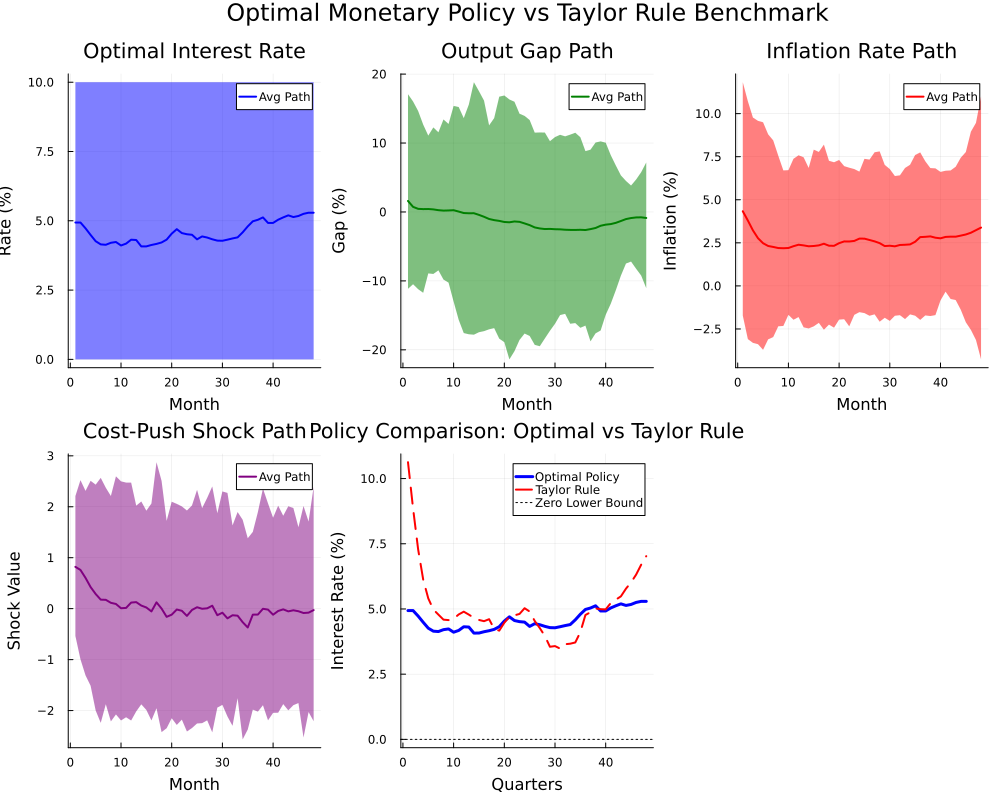

In [4]:
using Plots, Statistics

# Parameters
quarters = 1:T

# Collect all paths from results
π_mat = reduce(hcat, [r.π for r in results])
x_mat = reduce(hcat, [r.x for r in results])
i_mat = reduce(hcat, [r.i for r in results])
u_mat = reduce(hcat, [r.u for r in results])

# Compute averages
π_avg = mean(π_mat, dims=2)[:]
x_avg = mean(x_mat, dims=2)[:]
i_avg = mean(i_mat, dims=2)[:]
u_avg = mean(u_mat, dims=2)[:]

# Compute quantiles (row-wise)
function row_quantiles(mat, q)
    [quantile(mat[t, :], q) for t in 1:size(mat,1)]
end

π_p5  = row_quantiles(π_mat, 0.05)
π_p95 = row_quantiles(π_mat, 0.95)

x_p5  = row_quantiles(x_mat, 0.05)
x_p95 = row_quantiles(x_mat, 0.95)

i_p5  = row_quantiles(i_mat, 0.05)
i_p95 = row_quantiles(i_mat, 0.95)

u_p5  = row_quantiles(u_mat, 0.05)
u_p95 = row_quantiles(u_mat, 0.95)

# Plot with fan chart style
p1 = plot(quarters, i_avg,
     ribbon = (i_avg .- i_p5, i_p95 .- i_avg),  # confidence band
     label = "Avg Path",
     xlabel = "Month", ylabel = "Rate (%)",
     title = "Optimal Interest Rate",
     linewidth = 2,
     color = :blue,
     grid = true)

p2 = plot(quarters, x_avg,
     ribbon = (x_avg .- x_p5, x_p95 .- x_avg),
     label = "Avg Path",
     xlabel = "Month", ylabel = "Gap (%)",
     title = "Output Gap Path",
     linewidth = 2,
     color = :green,
     grid = true)

p3 = plot(quarters, π_avg,
     ribbon = (π_avg .- π_p5, π_p95 .- π_avg),
     label = "Avg Path",
     xlabel = "Month", ylabel = "Inflation (%)",
     title = "Inflation Rate Path",
     linewidth = 2,
     color = :red,
     grid = true)

p4 = plot(quarters, u_avg,
     ribbon = (u_avg .- u_p5, u_p95 .- u_avg),
     label = "Avg Path",
     xlabel = "Month", ylabel = "Shock Value",
     title = "Cost-Push Shock Path",
     linewidth = 2,
     color = :purple,
     grid = true)

# Add Taylor rule to your existing plot
p5 = plot(quarters, i_avg, 
     label="Optimal Policy", 
     linewidth=3, 
     color=:blue)
     plot!(p5, quarters, i_taylor, label="Taylor Rule", linewidth=2, 
     color=:red, linestyle=:dash)
     hline!(p5, [0], label="Zero Lower Bound", color=:black, linestyle=:dot)
     title!(p5, "Policy Comparison: Optimal vs Taylor Rule")
     xlabel!(p5, "Quarters")
     ylabel!(p5, "Interest Rate (%)")


# Add to your existing plot layout
plot(p1, p2, p3, p4, p5,  # Replace p4 with p5, or make it (2,3) layout
     layout = (2, 3),
     size = (1000, 800),
     plot_title = "Optimal Monetary Policy vs Taylor Rule Benchmark")


## Stochastic with two shocks

In [5]:
using JuMP, Ipopt
using LinearAlgebra
using Distributions

# Parameters To Be Estimated/Tweaked Later
T = 60       # Time horizon
T_Half = 31  # Time at next Shock
β = 0.99     # Discount factor
β_inf = 0.96 # Expected Inflation Coefficient
γ = -0.08    # Slope of Phillips Curve
σ = 1.0      # Intertemporal elasticity of substitution
ω = 0.5      # Weight on output gap in loss function
ρ_u = 0.8    # Persistence of cost-push shock
u₁ = 1.0     # Initial cost-push shock
u2 = -1.0    # Second cost-push shock
λ = 0.1      # Weight to smooth interest rates between quarters
N = 100      # Number of Monte Carlo trials
shock_std = 0.79  # Standard deviation of shocks

results = []

for trial in 1:N
    # Model setup
    model = Model(Ipopt.Optimizer)
    set_silent(model)

    # Variables
    @variables(model, begin
        π[1:T]      # Inflation
        x[1:T]      # Output gap
        i[1:T]      # Nominal interest rate
        u[1:T]      # Cost-push shock (AR(1))
    end)

    # Random shocks
    ε = randn(T) * shock_std

    # Shock process
    @constraint(model, u[1] == u₁ + ε[1])
    @constraint(model, [t=2:31], u[t] == ρ_u * u[t-1] + ε[t])
    @constraint(model, u[32] == u2 + ε[32])
    @constraint(model, [t=33:T], u[t] == ρ_u * u[t-1] + ε[t])

    # Phillips Curve (with cost-push shock)
    @constraint(model, [t=1:T-1], π[t] == γ * x[t] + β_inf * π[t+1]+ u[t])

    # IS Curve (assuming natural rate rₜᶠ = 2% for simplicity)
    @constraint(model, [t=1:T-1], x[t] == x[t+1] - (1/σ) * (i[t] - π[t+1] - 2.0))

    # ZLB Constraint
    @constraint(model, [t=1:T], i[t] >= 0.0)

    # Upper Bound Constraint on interest
    @constraint(model, [t=1:T], i[t] <= 10.0)

    # Objective: Minimize loss function (πₜ² + ωxₜ²)
    @objective(model, Min, sum(β^(t-1) * ((π[t] - 2)^2 + ω * x[t]^2 + λ * (i[t]-i[t-1])^2) for t in 2:T))

    # Solve
    optimize!(model)

    push!(results, (
        π = value.(π),
        x = value.(x),
        i = value.(i),
        u = value.(u),
        loss = objective_value(model)
    ))
end

# Extract results   # Compute averages across trials (Monte Carlo estimates)
π_avg = mean(reduce(hcat, [r.π for r in results]), dims=2)
x_avg = mean(reduce(hcat, [r.x for r in results]), dims=2)
i_avg = mean(reduce(hcat, [r.i for r in results]), dims=2)


"""Taylor Rule Comparison for Performance Validation"""

# Calculate Taylor rule benchmark
i_taylor = taylor_rule(π_avg, x_avg)

opt_loss = calculate_loss(π_avg, x_avg, i_avg)
taylor_loss = calculate_loss(π_avg, x_avg, i_taylor)
improvement = (taylor_loss - opt_loss) / taylor_loss * 100

println("Performance vs Taylor Rule:")
println("  Optimal Policy Loss: $(round(opt_loss, digits=4))")
println("  Taylor Rule Loss: $(round(taylor_loss, digits=4))")
println("  Improvement: $(round(improvement, digits=2))%")

Performance vs Taylor Rule:
  Optimal Policy Loss: 151.8968
  Taylor Rule Loss: 153.2588
  Improvement: 0.89%


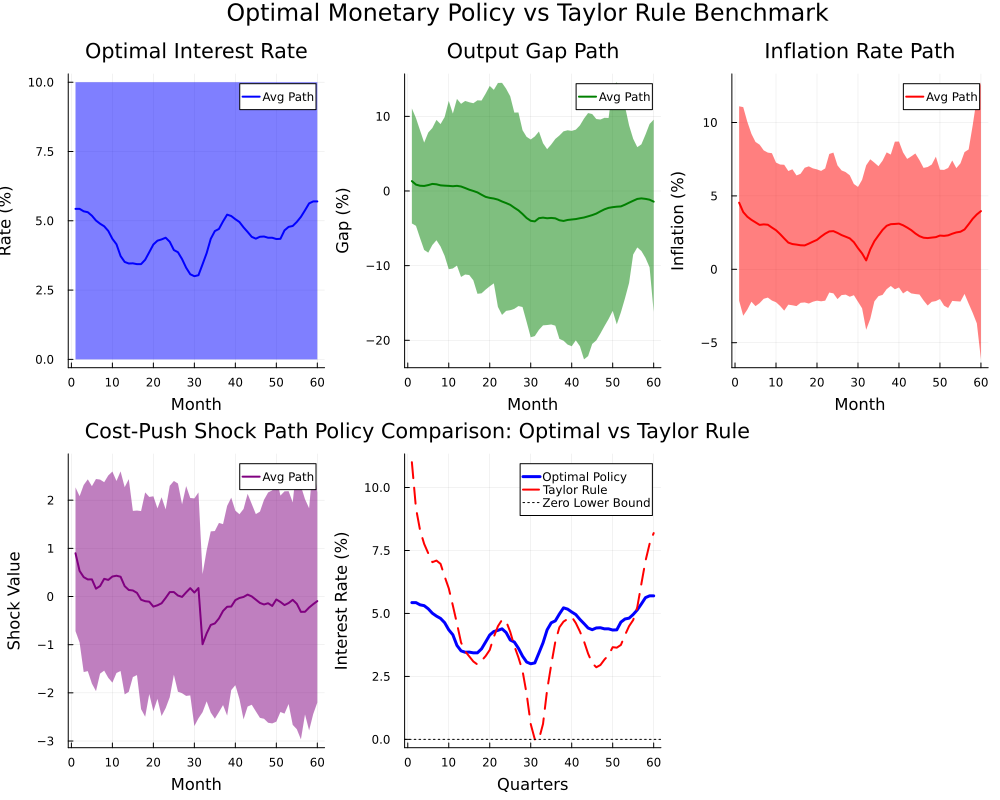

In [6]:
using Plots, Statistics

# Parameters
quarters = 1:T

# Collect all paths from results
π_mat = reduce(hcat, [r.π for r in results])
x_mat = reduce(hcat, [r.x for r in results])
i_mat = reduce(hcat, [r.i for r in results])
u_mat = reduce(hcat, [r.u for r in results])

# Compute averages
π_avg = mean(π_mat, dims=2)[:]
x_avg = mean(x_mat, dims=2)[:]
i_avg = mean(i_mat, dims=2)[:]
u_avg = mean(u_mat, dims=2)[:]

# Compute quantiles (row-wise)
function row_quantiles(mat, q)
    [quantile(mat[t, :], q) for t in 1:size(mat,1)]
end

π_p5  = row_quantiles(π_mat, 0.05)
π_p95 = row_quantiles(π_mat, 0.95)

x_p5  = row_quantiles(x_mat, 0.05)
x_p95 = row_quantiles(x_mat, 0.95)

i_p5  = row_quantiles(i_mat, 0.05)
i_p95 = row_quantiles(i_mat, 0.95)

u_p5  = row_quantiles(u_mat, 0.05)
u_p95 = row_quantiles(u_mat, 0.95)

# Plot with fan chart style
p1 = plot(quarters, i_avg,
     ribbon = (i_avg .- i_p5, i_p95 .- i_avg),  # confidence band
     label = "Avg Path",
     xlabel = "Month", ylabel = "Rate (%)",
     title = "Optimal Interest Rate",
     linewidth = 2,
     color = :blue,
     grid = true)

p2 = plot(quarters, x_avg,
     ribbon = (x_avg .- x_p5, x_p95 .- x_avg),
     label = "Avg Path",
     xlabel = "Month", ylabel = "Gap (%)",
     title = "Output Gap Path",
     linewidth = 2,
     color = :green,
     grid = true)

p3 = plot(quarters, π_avg,
     ribbon = (π_avg .- π_p5, π_p95 .- π_avg),
     label = "Avg Path",
     xlabel = "Month", ylabel = "Inflation (%)",
     title = "Inflation Rate Path",
     linewidth = 2,
     color = :red,
     grid = true)

p4 = plot(quarters, u_avg,
     ribbon = (u_avg .- u_p5, u_p95 .- u_avg),
     label = "Avg Path",
     xlabel = "Month", ylabel = "Shock Value",
     title = "Cost-Push Shock Path",
     linewidth = 2,
     color = :purple,
     grid = true)

# Add Taylor rule to your existing plot
p5 = plot(quarters, i_avg, 
     label="Optimal Policy", 
     linewidth=3, 
     color=:blue)
     plot!(p5, quarters, i_taylor, label="Taylor Rule", linewidth=2, 
     color=:red, linestyle=:dash)
     hline!(p5, [0], label="Zero Lower Bound", color=:black, linestyle=:dot)
     title!(p5, "Policy Comparison: Optimal vs Taylor Rule")
     xlabel!(p5, "Quarters")
     ylabel!(p5, "Interest Rate (%)")


# Add to your existing plot layout
plot(p1, p2, p3, p4, p5,  # Replace p4 with p5, or make it (2,3) layout
     layout = (2, 3),
     size = (1000, 800),
     plot_title = "Optimal Monetary Policy vs Taylor Rule Benchmark")
